In [82]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline , interp1d
from scipy.optimize import curve_fit
from heapq import nsmallest
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

# Lectura de datos

In [3]:
#Configuraciones iniciales
FILE = 'zetaAur-eclipse_B_2019_11_15_23_52_17.dat'
LMIN = 3931.66
LMAX = 3935.66
LLIN = 3933.66
RANG = 0.2
NSPL = 200

In [4]:
#importar datos
Data = pd.read_csv(FILE, delimiter = ' ', header = None)
Data.columns = ['L','I', 'C']
Data['L'] = Data['L']*10 #unidades en Amstrong

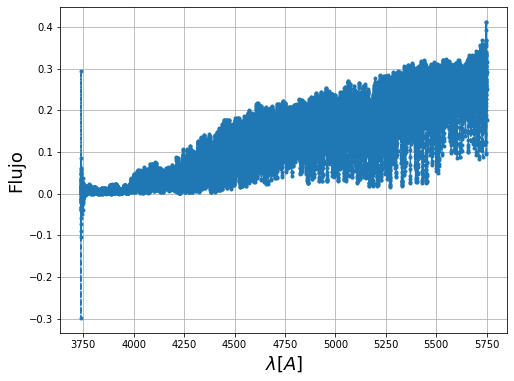

In [5]:
#Graficamos todo el ezspectro en la banda del azul
plt.figure(figsize = [8,6])
plt.plot(Data['L'],Data['I'],marker='.', ls='--')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [6]:
#Recortamos en el rango de la línea K
New_Data = Data[(Data['L'] >= LMIN) & (Data['L'] <= LMAX)] #Se encuentran los valores cercanos a la config inicial
New_Data.index = list(range(len(New_Data)))
L_min = New_Data['L'].min()
L_max = New_Data['L'].max()

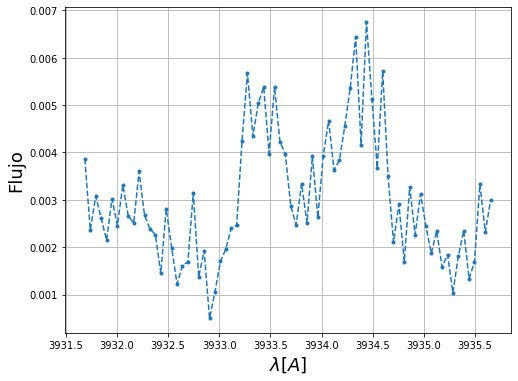

In [7]:
#Graficamos los datos del segmento de la línea K
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls='--')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Ajuste del espectro usando Splines

In [8]:
def ReductorDatos(lamnda, Intensidad,start,end,paso):
    
    List_pasos = np.arange(start,end, paso)
    Datos_agrupados = {}
    Datos_agrupados['L'] = []
    Datos_agrupados['I'] = []
    for i in range(1,len(List_pasos)):
        Agrup_lamnda = lamnda[(lamnda >= List_pasos[i-1]) & (lamnda < List_pasos[i])]
        
        Datos_agrupados['L'].append(Agrup_lamnda)
        Datos_agrupados['I'].append(Intensidad[  Agrup_lamnda.index  ]) # Agrup_lamnda.index  obtiene la llave compartida
    return Datos_agrupados

In [70]:
ajustedatos = ReductorDatos(New_Data['L'], New_Data['I'],3931.6,3935.6,0.105)

In [83]:
newdatosL = [] 
newdatosI = []
for i in range(len(ajustedatos['I'])):
    newdatosL.append(ajustedatos['L'][i].median())
    newdatosI.append(ajustedatos['I'][i].median())
    datosajustI = [x for x in newdatosI if str(x) != 'nan']
    datosajustL = [x for x in newdatosL if str(x) != 'nan']
cs = InterpolatedUnivariateSpline(datosajustL,datosajustI)
xs =  np.linspace(L_min,  L_max, 100)

In [84]:
datosajust = pd.DataFrame({'L': datosajustL, 'I': datosajustI})

In [85]:
#Falta hacer bien el ajuste, por el momento tomo los datos del código de C++
Data_s = pd.read_csv('HIEW_Spline.txt', delimiter = ' ', header = None) #Datos ajuste
Data_s.columns = ['L','I']

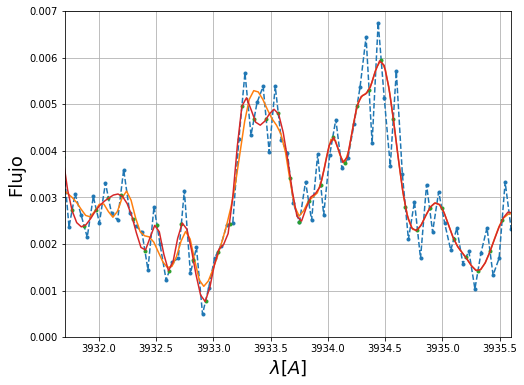

In [86]:
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls='--')
plt.plot(Data_s['L'],Data_s['I'],marker='', ls='-')
plt.plot(datosajust['L'],datosajust['I'],marker='.', ls='')
plt.plot(xs,cs(xs),marker='', ls='-')
plt.grid()
plt.ylim(0,0.007)
plt.xlim(3931.7,3935.6)
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Valores máximos, mínimos y medios de intensidad

In [87]:
#Creo dos dataFrame desde el mínimo K3 hacía la izquiera y la derecha, teniendo en cuenta un rango de ese mínimo
b = datosajust[(datosajust['L'] >= LMIN) & (datosajust['L'] <= (LLIN - RANG))]
r = datosajust[(datosajust['L'] >= (LLIN + RANG)) & (datosajust['L'] <= LMAX)]
b.index = list(range(len(b)))
r.index = list(range(len(r)))

In [88]:
#Calculo los máximos y mínimos para cada uno de los picos
k1b=b[b['I'] == b['I'].min()]
k2b=b[b['I'] == b['I'].max()]
k1r=r[r['I'] == r['I'].min()]
k2r=r[r['I'] == r['I'].max()]
#Se usa float() para poder hacer operaciones entre datos de un dataFrame
#Hago un DataFrame que va desde K1 a K2, para B y R
pico1 = b[(b['L'] >= float(k1b['L'])) & (b['L'] <= float(k2b['L']))]
pico2 = r[(r['L'] >= float(k2r['L'])) & (r['L'] <= float(k1r['L']))]
pico1.index = list(range(len(pico1)))
pico2.index = list(range(len(pico2)))
#Calculo la intensidad media entre K1 y K2 para B y R
Ibm_teo = float(k1b['I']) + (float(k2b['I']) - float(k1b['I']))/2 #Intensidad teórica media
Ibm_ajus = nsmallest(1, pico1['I'],  key = lambda x: abs(x - Ibm_teo))[0] #El más cercano en el ajuste a la intensidad media
B_m = pico1[pico1['I'] == Ibm_ajus] 

Irm_teo = float(k1r['I']) + (float(k2r['I']) - float(k1r['I']))/2
Irm_ajus = nsmallest(1, pico2['I'],  key = lambda x: abs(x - Irm_teo))[0]
R_m = pico2[pico2['I'] == Irm_ajus]

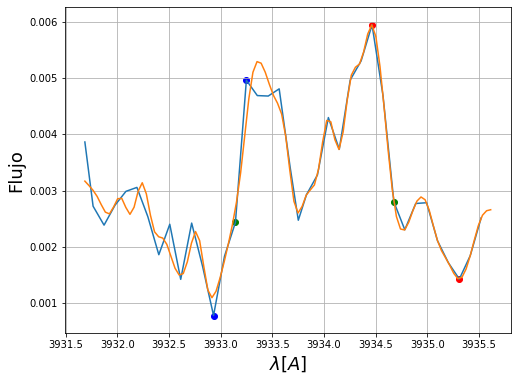

In [89]:
#Graficamos ajuste y puntos calculados anteriormente
plt.figure(figsize = [8,6])
plt.plot(datosajust['L'],datosajust['I'],marker='', ls='-')
plt.plot(Data_s['L'],Data_s['I'],marker='', ls='-')
plt.scatter(k1b['L'], k1b['I'], color = 'blue')
plt.scatter(k1r['L'], k1r['I'], color = 'r')
plt.scatter(k2b['L'], k2b['I'], color = 'blue')
plt.scatter(k2r['L'], k2r['I'], color = 'r')
plt.scatter(B_m['L'], B_m['I'], color = 'green')
plt.scatter(R_m['L'], R_m['I'], color = 'green')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Calculo del ancho equivalente

In [78]:
#Calculo de la incertidumbre de lambda para el punto medio

valor_medioB = New_Data[New_Data['L'] == nsmallest(1, New_Data['L'],  key = lambda x: abs(x - float(B_m['L'])))[0]]
indb = valor_medioB.index[0]

if float(valor_medioB['L']) < float(B_m['L']):
    Lmbinf = valor_medioB
    Lmbsup = pd.DataFrame( [[New_Data['L'][indb+1], New_Data['I'][indb+1]]], columns = ('L','I'))
else:
    Lmbsup = valor_medioB
    Lmbinf = pd.DataFrame( [[New_Data['L'][indb-1], New_Data['I'][indb-1]]], columns = ('L','I') )

valor_medioR = New_Data[New_Data['L'] == nsmallest(1, New_Data['L'],  key = lambda x: abs(x - float(R_m['L'])))[0]]
indr = valor_medioR.index[0]

if float(valor_medioR['L']) < float(R_m['L']):
    Lmrinf = valor_medioR
    Lmrsup = pd.DataFrame( [[New_Data['L'][indr+1], New_Data['I'][indr+1]]], columns = ('L','I') )
else:
    Lmrsup = valor_medioR
    Lmrinf = pd.DataFrame( [[New_Data['L'][indr-1], New_Data['I'][indr-1]]], columns = ('L','I') )

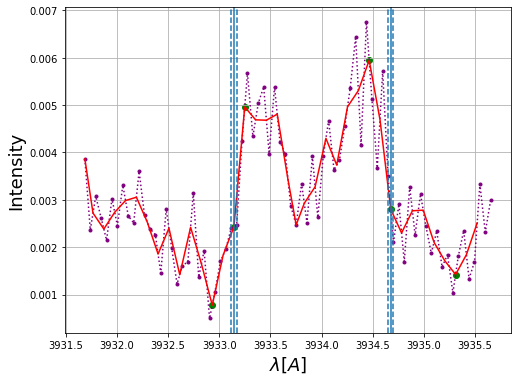

In [79]:
#Graficamos todos los calculos anteriores
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls=':', color='purple') #datos
plt.plot(datosajust['L'],datosajust['I'],marker='', ls='-', color='r') #ajuste
plt.scatter(k1b['L'], k1b['I'], color='green') #Mínimo azul
plt.scatter(k1r['L'], k1r['I'], color='green') #minimo rojo
plt.scatter(k2b['L'], k2b['I'], color='green') #maximo azul
plt.scatter(k2r['L'], k2r['I'], color='green') #maximo rojo
plt.scatter(B_m['L'], B_m['I'], color='green') #punto medio azul
plt.scatter(R_m['L'], R_m['I'], color='green') #punto medio rojo

plt.axvline(float(B_m['L']), ls='-') #límite derecho del ancho de la línea
plt.axvline(float(Lmbsup['L']), ls='--') #incertudumbre izq
plt.axvline(float(Lmbinf['L']), ls='--') #incertidumbre derecha

plt.axvline(float(Lmrsup['L']), ls='--')
plt.axvline(float(R_m['L']), ls='-')
plt.axvline(float(Lmrinf['L']), ls='--')
plt.grid()
plt.ylabel("Intensity",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [80]:
W_0 = float(R_m['L']) -float(B_m['L'])
deltabm = ( float(Lmbsup['L']) - float(B_m['L']) + float(B_m['L']) - float(Lmbinf['L']))/2
deltarm = ( float(Lmrsup['L']) - float(R_m['L']) + float(R_m['L']) - float(Lmrinf['L']))/2
deltaW = np.sqrt(deltabm**2 + deltarm**2)
print("W_0 = {} +- {} [A]".format(W_0, deltaW))

W_0 = 1.5340806932103987 +- 0.037405526806261205 [A]
